# Final Project: Model Code
### Nasiba Adilova, Heather Leighton-Dick, Madison Massie

In [3]:
#libraries/modules
import imblearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from collections import Counter

from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC as svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve

## Importing the Dataset, Cleaning, Renaming Columns

In [4]:
df_glass = pd.read_csv('glass (1).csv')

df_glass.rename(columns = {'RI':'RIRefractive index', 'Na':'NaSodium', 'Mg': 'MGMagnesium', 'Al': 'AlAluminum', 'Si': 'SiSilicon', 'K':'KPotassium', 'Ca':'CaCalcium','Ba': 'BaBarium', 'Fe': 'FeIron' }, inplace = True)
df_glass

,RIRefractive index,NaSodium,MGMagnesium,AlAluminum,SiSilicon,KPotassium,CaCalcium,BaBarium,FeIron,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


### Imbalanced Dataset

In [10]:
#There are no observations of Type 4 Glass in this dataset
df_glass['Type'].unique()

array([1, 2, 3, 5, 6, 7])

In [12]:
#How many observations of each Type are in the dataset?
df_glass['Type'].value_counts(sort=False)

1    70
2    76
3    17
5    13
6     9
7    29
Name: Type, dtype: int64

### Finding the Allowable Range of Chemical Amounts in Each Type of Glass ("unit measurement: weight percent in corresponding oxide", per dataset specifications)

In [86]:
#Sodium
sodiumrange_bytype = df_glass.groupby('Type').apply(lambda x: x.NaSodium.max() - x.NaSodium.min())
print(sodiumrange_bytype)

Type
1    2.32
2    4.13
3    2.16
5    2.98
6    3.59
7    3.84
dtype: float64


In [77]:
#Magnesium
magrange_bytype = df_glass.groupby('Type').apply(lambda x: x.MGMagnesium.max() - x.MGMagnesium.min())
print(magrange_bytype)

Type
1    1.78
2    3.98
3    0.56
5    2.68
6    2.41
7    3.34
dtype: float64


In [78]:
#Aluminum
alumrange_bytype = df_glass.groupby('Type').apply(lambda x: x.AlAluminum.max() - x.AlAluminum.min())
print(alumrange_bytype)

Type
1    1.40
2    1.56
3    1.18
5    2.10
6    1.75
7    1.69
dtype: float64


In [79]:
#Silicon
sirange_bytype = df_glass.groupby('Type').apply(lambda x: x.SiSilicon.max() - x.SiSilicon.min())
print(sirange_bytype)

Type
1    2.35
2    4.64
3    1.65
5    3.99
6    3.04
7    4.92
dtype: float64


In [80]:
#Potassium
Krange_by_type = df_glass.groupby('Type').apply(lambda x: x.KPotassium.max() - x.KPotassium.min())
print(Krange_by_type)

Type
1    0.69
2    1.10
3    0.61
5    6.08
6    0.00
7    2.70
dtype: float64


In [82]:
#Calcium
CArange_by_type = df_glass.groupby('Type').apply(lambda x: x.CaCalcium.max() - x.CaCalcium.min())
print(Carange_by_type)

Type
1    2.39
2    9.11
3    1.33
5    6.63
6    4.57
7    4.33
dtype: float64


In [84]:
#Iron
FErange_by_type = df_glass.groupby('Type').apply(lambda x: x.FeIron.max() - x.FeIron.min())
print(FErange_by_type)

Type
1    0.31
2    0.35
3    0.37
5    0.51
6    0.00
7    0.09
dtype: float64


In [85]:
#Barium
BArange_by_type = df_glass.groupby('Type').apply(lambda x: x.BaBarium.max() - x.BaBarium.min())
print(BArange_by_type)

Type
1    0.69
2    3.15
3    0.15
5    2.20
6    0.00
7    2.88
dtype: float64


## Applying SMOTE

In [28]:
#SMOTE
data = df_glass.values
# split into input and output elements
X, y = data[:, :-1], data[:, -1]
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

## Train Test Split and Standard Scaling

In [29]:
#split into train test split portions
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
#Performing Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
## Quick sanity check with the shapes of Training and Testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

## Training SVM Model Candidates (Linear, Radial Basis Function, Polynomial Kernel)

### Linear Kernel Model

In [64]:
# training a linear SVM classifier
svm_linmodel = SVC(kernel = 'linear', C = 1)
svm_linmodel.fit(X_train, y_train)
svm_linpredictions = svm_linmodel.predict(X_test)
 
#print accuracy and F1 score:
lin_accuracy = svm_linmodel.score(X_test, y_test)
print("Accuracy (Linear Kernel): ", "%.2f" % (lin_accuracy*100)) 
lin_f1 = f1_score(y_test, svm_linpredictions, average='weighted')
print('F1 (Linear Kernel): ', "%.2f" % (lin_f1*100))

Accuracy (Linear Kernel):  83.70
F1 (Linear Kernel):  83.52


In [87]:
print(classification_report(y_test, svm_linpredictions))

              precision    recall  f1-score   support

           0       0.79      0.65      0.71        17
           1       0.77      0.53      0.62        19
           2       0.53      1.00      0.69        10
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        18

    accuracy                           0.84        92
   macro avg       0.85      0.86      0.84        92
weighted avg       0.86      0.84      0.84        92



### Radial Basis Function Model

In [65]:
#training an RBF classifier:
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=1).fit(X_train, y_train)
rbf_pred = rbf.predict(X_test)

#printing accuracy and F1 scores:
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  86.96
F1 (RBF Kernel):  86.92


In [88]:
print(classification_report(y_test, rbf_pred))

              precision    recall  f1-score   support

           0       0.85      0.65      0.73        17
           1       0.79      0.79      0.79        19
           2       0.64      0.90      0.75        10
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       0.94      0.94      0.94        18

    accuracy                           0.87        92
   macro avg       0.87      0.88      0.87        92
weighted avg       0.88      0.87      0.87        92



### Polynomial Kernel Model

In [66]:
#training a Polynomial classifer:
poly = svm.SVC(kernel='poly', degree=3, C=10).fit(X_train, y_train)
poly_pred = poly.predict(X_test)

#printing accuracy and F1 scores:
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial kernel):  78.26
F1 (Polynomial kernel):  78.63


In [89]:
print(classification_report(y_test, poly_pred))

              precision    recall  f1-score   support

           0       0.79      0.65      0.71        17
           1       0.78      0.37      0.50        19
           2       0.38      0.90      0.53        10
           3       1.00      0.93      0.96        14
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        18

    accuracy                           0.78        92
   macro avg       0.82      0.81      0.78        92
weighted avg       0.85      0.78      0.79        92



In [ ]:
### Conclusion: The RBF Kernel method gave the best score of the three SVM models, with an accuracy of 86.96. 
### RBF is the default SVM model, and uses C and gamma parameters

## Plotting Refractive Index v Chemical Components

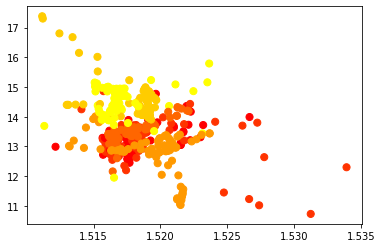

In [68]:
#refractive index v sodium
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

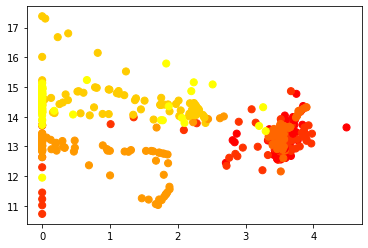

In [75]:
#refractive index v magnesium
plt.scatter(X[:, 2], X[:, 1], c=y, s=50, cmap='autumn');

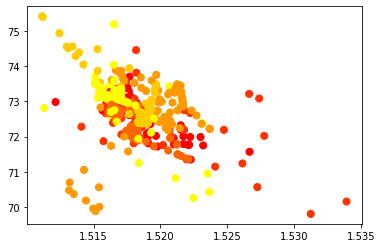

In [70]:
#refractive index v silicon
plt.scatter(X[:, 0], X[:, 4], c=y, s=50, cmap='autumn');

## Confusion Matrices for Each Model

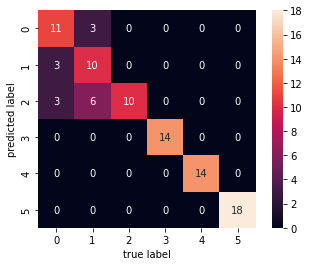

In [94]:
#Confusion matrix for Linear Kernel model
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, svm_linpredictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('true label')
plt.ylabel('predicted label');



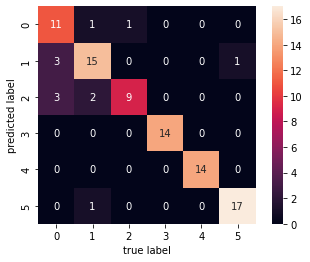

In [95]:
#Confusion Matrix for RBF model
mat = confusion_matrix(y_test, rbf_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('true label')
plt.ylabel('predicted label');

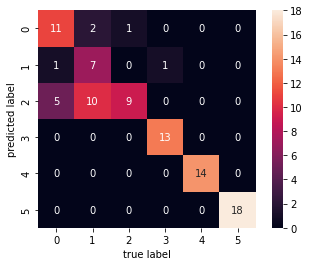

In [96]:
#Confusion Matrix for Polynomial Kernel model
mat = confusion_matrix(y_test, poly_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Plotting the SVM RBF Model

In [91]:
from ipywidgets import interact, fixed
from mpl_toolkits import mplot3d
r = np.exp(-(X ** 2).sum(1))

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

## ROC Curves for the RBF Model

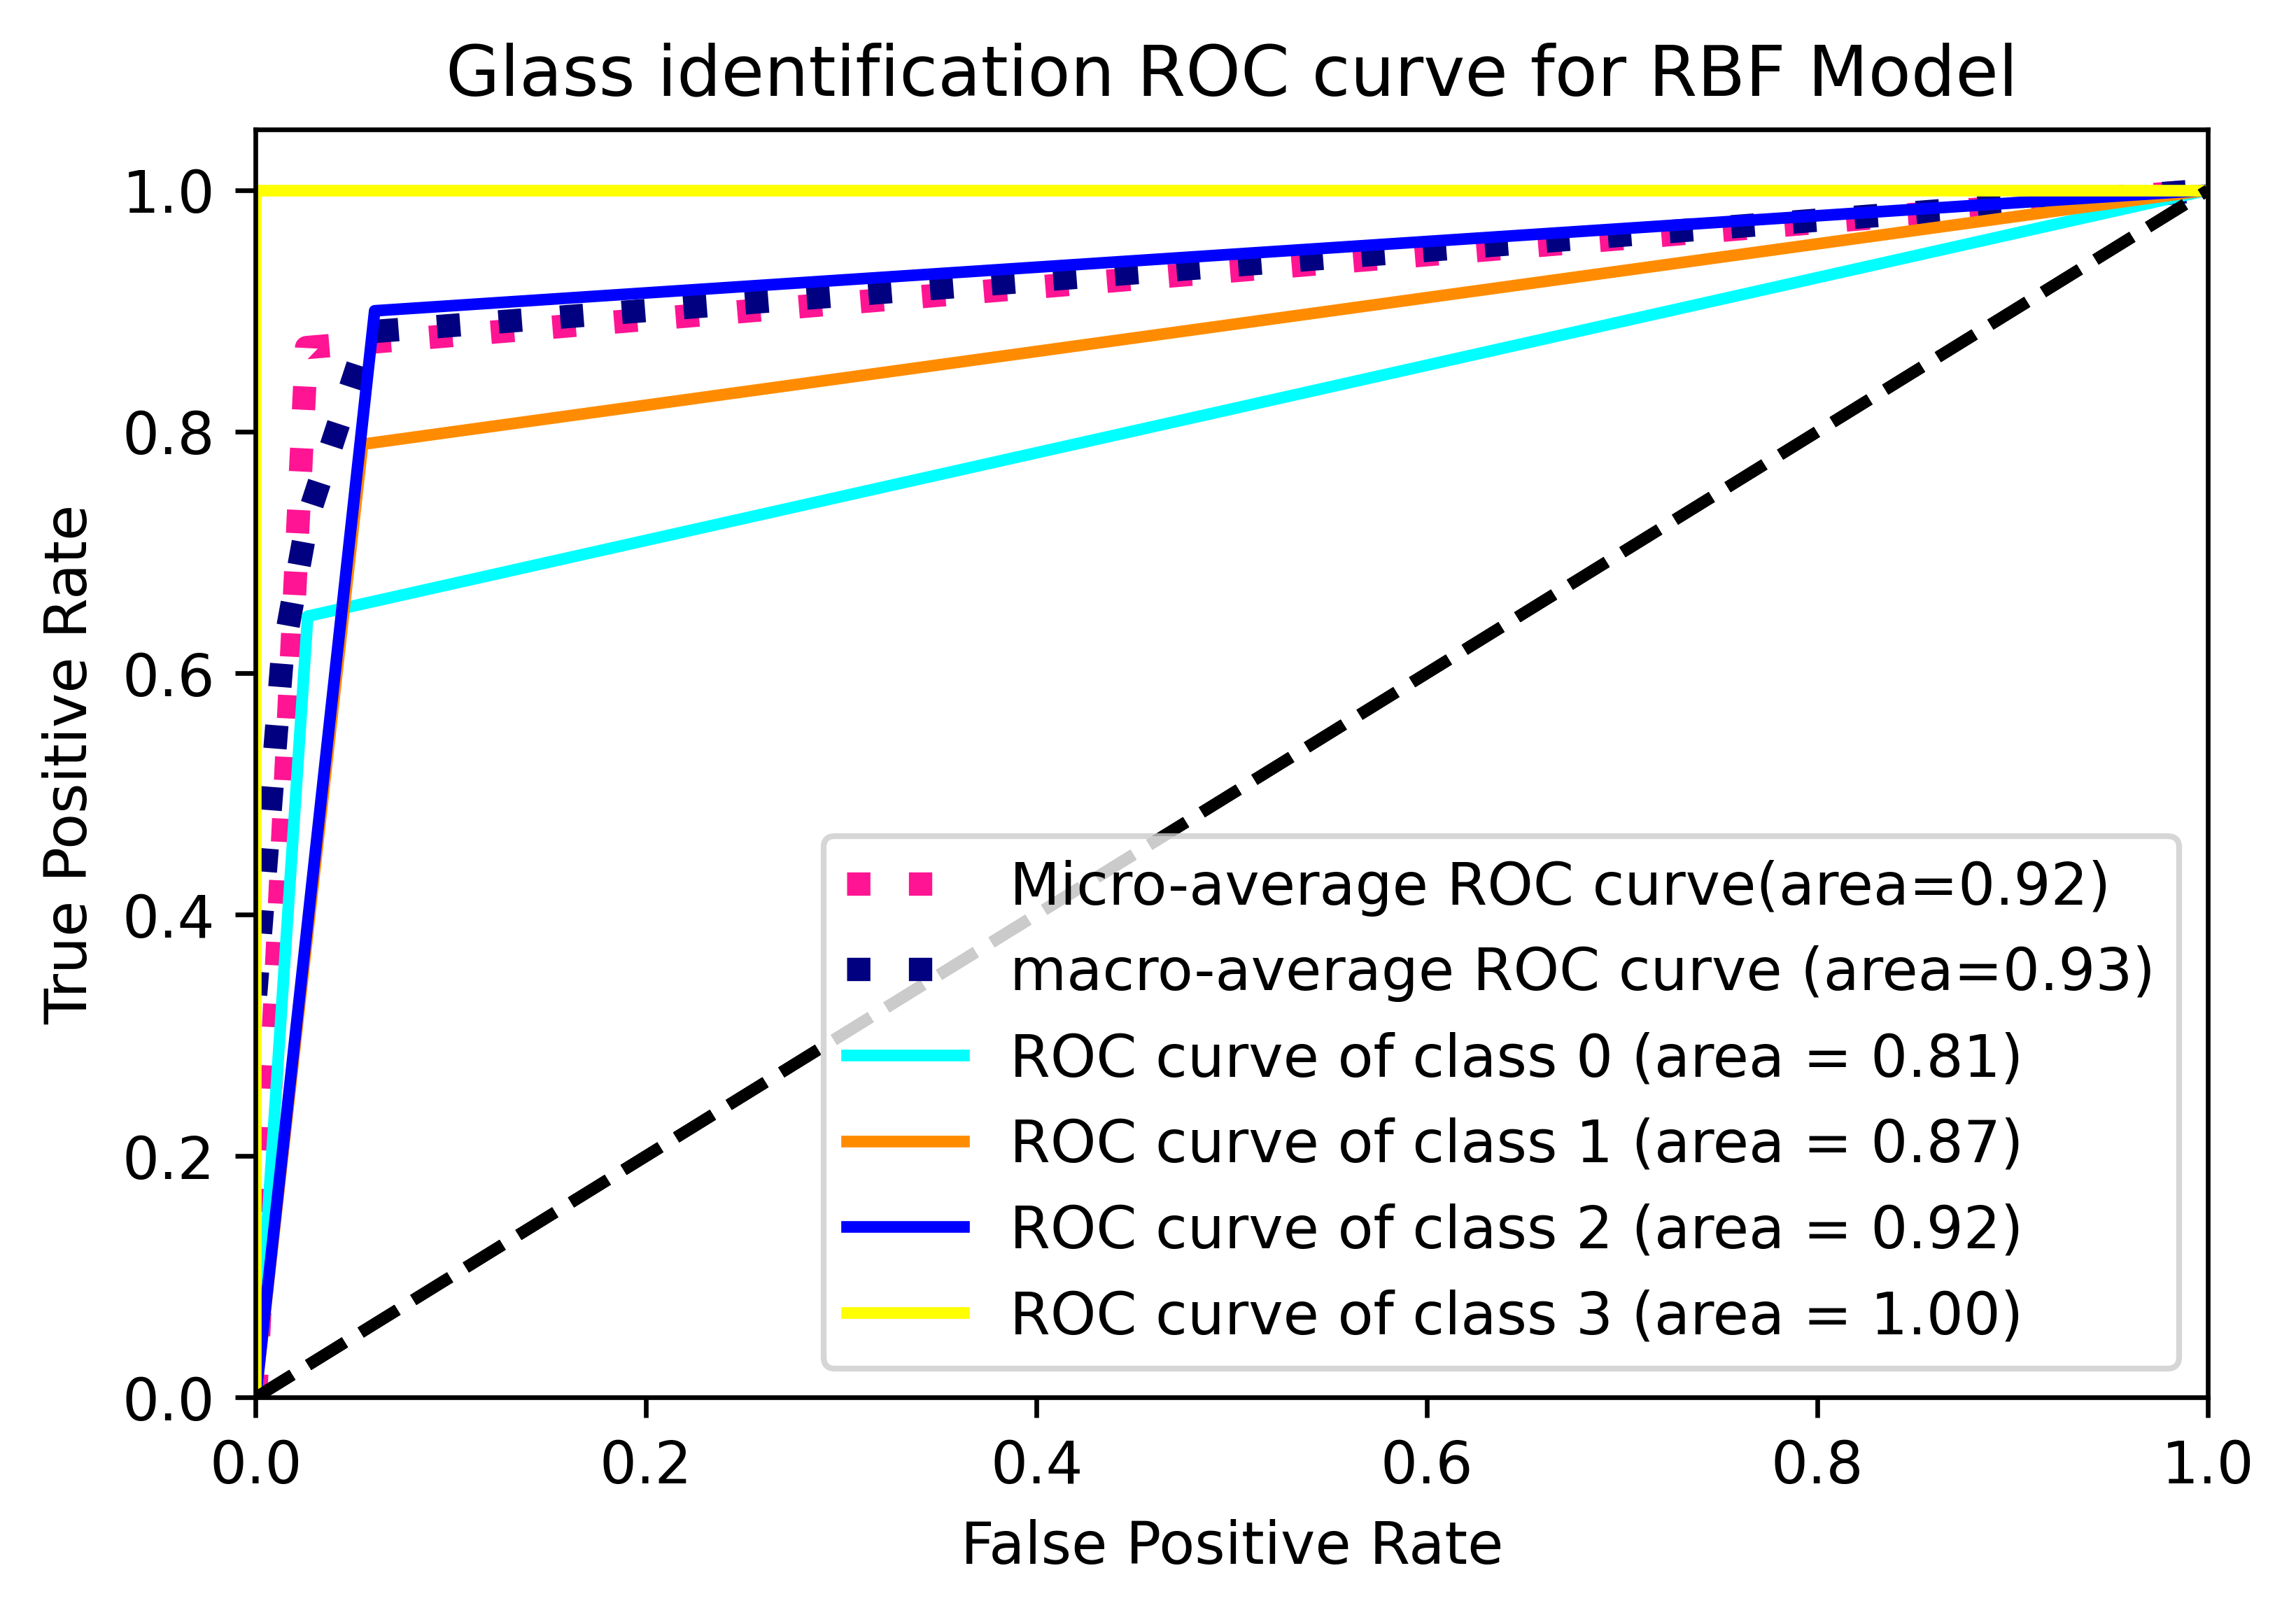

In [127]:
#ROC function and plotting courtesy of Nasiba
def plot_roc_curve(y_test,rbf_pred):
    num_classes = len(np.unique(y_test))
    y_test = label_binarize(y_test,classes =np.arange(num_classes))
    rbf_pred = label_binarize(rbf_pred,classes=np.arange(num_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i],tpr[i],_ = roc_curve(y_test[:, i],rbf_pred[:, i])
        roc_auc[i] = auc(fpr[i],tpr[i])
        
        
    # Compute micro-average ROC curve and ROC area
    fpr['micro'], tpr['micro'],_ = roc_curve(y_test.ravel(),rbf_pred.ravel())
    roc_auc['micro'] = auc(fpr['micro'],tpr['micro'])
    
    #First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr +=np.interp(all_fpr,fpr[i], tpr[i])
        
        
    # Finally average it and compute AUC
    mean_tpr/=num_classes
    
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'],tpr['macro'])
    
    # Plot all ROC curves
    # plt.figure(figsize=(10,5))
    plt.figure(dpi=600)
    lw = 2
    plt.plot(fpr['micro'],tpr['micro'],
            label = 'Micro-average ROC curve(area={0:0.2f})'.format(roc_auc['micro']),
            color = 'deeppink', linestyle=':', linewidth=4,)
    
    plt.plot(fpr['macro'],tpr['macro'],
            label = 'macro-average ROC curve (area={0:0.2f})'.format(roc_auc['macro']),
            color='navy', linestyle=':',linewidth=4,)
    
    colors = ['aqua','darkorange','blue', 'yellow']
    for i, color in zip(range(num_classes),colors):
        plt.plot(fpr[i],tpr[i],color=color,lw=lw,
                label = 'ROC curve of class {0} (area = {1:0.2f})'.format(i,roc_auc[i]),)
        
        
        plt.plot([0,1],[0,1], 'k--',lw =lw)
        plt.xlim([0.0,1.0])
        plt.ylim([0.0,1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Glass identification ROC curve for RBF Model')
        plt.legend()

plot_roc_curve(y_test,rbf_pred)

NameError: name 'make_meshgrid' is not defined

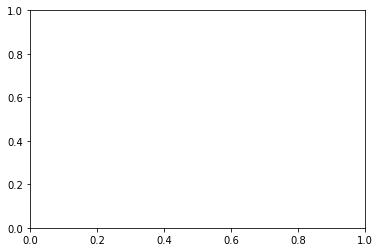

In [99]:
X = X_test [:, :2] 
y = svm_predictions


fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, svm_model_linear, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('y label here')
ax.set_xlabel('x label here')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

## Importing Modules for KNN and ANN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectPercentile, chi2
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, auc, roc_curve, f1_score, classification_report
from itertools import cycle

from tensorflow.random import set_seed
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from ann_visualizer.visualize import ann_viz

In [2]:
df_glass = pd.read_csv('glass (1).csv')
df_glass.rename(columns = {'RI':'RI/Refractive index', 'Na':'Na/Sodium', 'Mg': 'MG/Magnesium', 
                           'Al': 'Al/Aluminum', 'Si': 'Si/Silicon', 'K':'K/Potassium', 'Ca':'Ca/Calcium',
                           'Ba': 'Ba/Barium', 'Fe': 'Fe/Iron' }, inplace = True)
data = df_glass.values
# split into input and output elements
X, y = data[:, :-1], data[:, -1]
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [3]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size = 0.2, random_state=42)

## Creating KNN Model

In [4]:
def optimal_k(X_train, X_test, y_train, y_test, stop=100):
    #Initialize knn_score and k
    knn_score, k = 0, 0
    #Loop through the odd values from 3 to the stop value + 1
    for n in range(3, stop+1, 2):
        #Generate KNN object with n neighbors
        knn=KNeighborsClassifier(n_neighbors=n)
        #Fit the model using X_train and y_train
        knn.fit(X_train, y_train)
        #Check if the new score of KNN is greater than the current max KNN score
        if knn.score(X_test, y_test) > knn_score:
            #If the new score of KNN is greater, set it as the new max and save the n value
            knn_score = knn.score(X_test, y_test)
            k = n
    #Print the optimal k value and it's KNN score
    print('Optimal k:', k, 'KNN Score:',knn_score)
    return k

In [5]:
def knn_model(X_train, X_test, y_train, y_test):
    #Obtain optimal k value
    k = optimal_k(X_train, X_test, y_train, y_test)
    #Setup the parameters to test on the KNN model
    params = {'n_neighbors': [k],
              'metric': ['minkowski', 'euclidean', 'manhattan'],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': range(10, 100, 5),
              'p': [1, 2]}
    #Run the KNN model through the search, using the specified parameters and 5 cross-fold validation
    gs = GridSearchCV(KNeighborsClassifier(), param_grid = params, cv=5, scoring = 'accuracy')
    #Fit the search to the training data
    gs.fit(X_train, y_train)

    #Return the tuned KNN model
    return gs.best_estimator_

In [6]:
#Create a KNN object using the created function
knn = knn_model(X_train, X_test, y_train, y_test)
#Obtain the predicted y scores using X_train (to check for underfitting)
knn_train = knn.predict(X_train)
#Obtain the predicted y scores using X_test
knn_pred = knn.predict(X_test)

#Create a DataFrame of the X_test values, the features, and the true and predicted labels
knn_glass = pd.DataFrame(X_test, columns=df_glass.columns[:-1])
knn_glass['True Labels'] = y_test
knn_glass['Predicted Labels'] = knn_pred
knn_glass.head()

Optimal k: 5 KNN Score: 0.8586956521739131


,RI/Refractive index,Na/Sodium,MG/Magnesium,Al/Aluminum,Si/Silicon,K/Potassium,Ca/Calcium,Ba/Barium,Fe/Iron,True Labels,Predicted Labels
0,0.135055,0.551791,0.059731,0.187383,-0.033797,-0.542165,0.124287,-0.409449,-0.484393,4,4
1,1.484824,0.691866,1.117635,-2.042471,-1.209769,-0.426463,0.303348,-0.409449,-0.484393,0,0
2,0.297541,-1.056977,-1.366769,0.252890,1.433026,0.006544,1.493382,-0.409449,-0.484393,3,3
3,0.308328,-0.092542,0.859400,-0.489995,-0.898267,0.054809,-0.140701,-0.409449,-0.484393,0,0
4,-0.640440,-0.656790,0.844480,-0.560045,0.419627,0.004788,-0.417911,-0.409449,-0.484393,2,2


In [7]:
#Obtain the accuracy score of the training data (to check for underfitting)
print(accuracy_score(y_train, knn_train))

1.0


In [8]:
#Obtain the accuracy score of the test data (to check for overfitting and for the model's accuracy)
print(accuracy_score(y_test, knn_pred))

0.8913043478260869


In [9]:
#Generate the classification report for the model
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81        17
           1       0.93      0.74      0.82        19
           2       0.59      1.00      0.74        10
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       1.00      0.94      0.97        18

    accuracy                           0.89        92
   macro avg       0.90      0.91      0.89        92
weighted avg       0.92      0.89      0.90        92



## Feature Selection

In [10]:
#Run several feature selection functions using X and y
mi = mutual_info_classif(X, y, random_state=42)
f_score, _ = f_classif(X, y)
sp = SelectPercentile(chi2, percentile=10).fit(X, y)
#Create a DataFrame of the features and their scores
feats = pd.DataFrame(zip(df_glass.columns[:-1], mi, f_score, sp.scores_),
                  columns=['Feats', 'MI', 'F_Score', 'Chi-10'])
feats

,Feats,MI,F_Score,Chi-10
0,RI/Refractive index,0.556039,5.948233,0.000133
1,Na/Sodium,0.627434,120.763711,14.448531
2,MG/Magnesium,0.820999,242.509869,374.141552
3,Al/Aluminum,0.615238,86.370056,40.692774
4,Si/Silicon,0.379186,6.835110,0.256442
5,K/Potassium,0.745253,26.883375,183.915577
6,Ca/Calcium,0.669095,21.394126,18.025677
7,Ba/Barium,0.437899,129.829063,328.006100
8,Fe/Iron,0.183445,9.044332,7.704187


In [11]:
#Find the 3 features with the highest score for each function
top_3_feats = {}
for i in ['MI', 'F_Score', 'Chi-10']:
    top_3_feats[i] = feats.sort_values(by = i)['Feats'][:3].values
#Create a DataFrame of the top 3 features
top_3 = pd.DataFrame(top_3_feats)
top_3

,MI,F_Score,Chi-10
0,Fe/Iron,RI/Refractive index,RI/Refractive index
1,Si/Silicon,Si/Silicon,Si/Silicon
2,Ba/Barium,Fe/Iron,Fe/Iron


## Plotting KNN

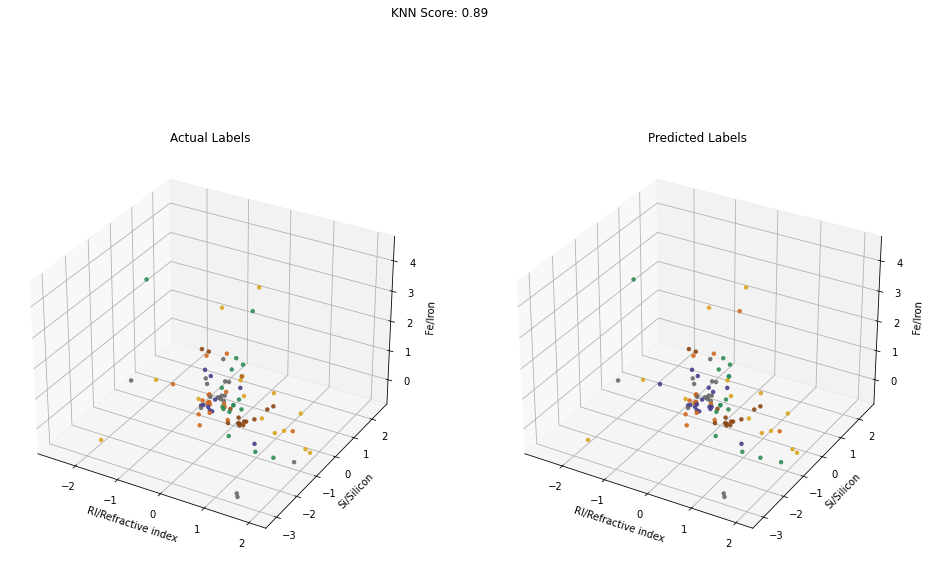

In [12]:
fig = plt.figure(figsize=(16, 10))
fig.suptitle(f'KNN Score: {knn.score(X_test, y_test).round(2)}')
#Get the X values for the top 3 features
xs = list(X_test[:, 0])
ys = list(X_test[:, 4])
zs = list(X_test[:, 8])

#Loop through y_test and assign each class a color
true_colors = []
for i in y_test:
    if i == 0:
        true_colors.append('seagreen')
    elif i == 1:
        true_colors.append('chocolate')
    elif i == 2:
        true_colors.append('darkslateblue')
    elif i == 3:
        true_colors.append('goldenrod')
    elif i == 4:
        true_colors.append('saddlebrown')
    else:
        true_colors.append('dimgrey')
        
#Loop through knn_pred and assign each class a color
pred_colors = []
for i in knn_pred:
    if i == 0:
        pred_colors.append('seagreen')
    elif i == 1:
        pred_colors.append('chocolate')
    elif i == 2:
        pred_colors.append('darkslateblue')
    elif i == 3:
        pred_colors.append('goldenrod')
    elif i == 4:
        pred_colors.append('saddlebrown')
    else:
        pred_colors.append('dimgrey')
        
#Add a 3-D graph of X_test and color by y_test value
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(xs, ys, zs, alpha=0.9, c=true_colors, edgecolors='none')
ax1.set_xlabel(df_glass.columns[0])
ax1.set_ylabel(df_glass.columns[4])
ax1.set_zlabel(df_glass.columns[8])
ax1.set_title('Actual Labels')

#Add a 3-D graph of X_test and color by y_pred value
ax2 = fig.add_subplot(122, projection='3d')    
ax2.scatter(xs, ys, zs, alpha=0.9, c=pred_colors, edgecolors='none')
ax2.set_xlabel(df_glass.columns[0])
ax2.set_ylabel(df_glass.columns[4])
ax2.set_zlabel(df_glass.columns[8])
ax2.set_title('Predicted Labels')
plt.show()

## Plotting ROC Curve for KNN

In [13]:
def plot_roc_curve(y_test,y_pred):
    num_classes = len(np.unique(y_test))
    y_test = label_binarize(y_test,classes =np.arange(num_classes))
    y_pred = label_binarize(y_pred,classes=np.arange(num_classes))
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i],tpr[i],_ = roc_curve(y_test[:, i],y_pred[:, i])
        roc_auc[i] = auc(fpr[i],tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr['micro'], tpr['micro'],_ = roc_curve(y_test.ravel(),y_pred.ravel())
    roc_auc['micro'] = auc(fpr['micro'],tpr['micro'])
    #First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr +=np.interp(all_fpr,fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr/=num_classes
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'],tpr['macro'])
    # Plot all ROC curves
    # plt.figure(figsize=(10,5))
    plt.figure(dpi=600)
    lw = 2
    plt.plot(fpr['micro'],tpr['micro'],
            label = 'Micro-average ROC curve(area={0:0.2f})'.format(roc_auc['micro']),
            color = 'deeppink', linestyle=':', linewidth=4,)
    plt.plot(fpr['macro'],tpr['macro'],
            label = 'macro-average ROC curve (area={0:0.2f})'.format(roc_auc['macro']),
            color='navy', linestyle=':',linewidth=4,)
    colors = cycle(['aqua','darkorange','darkgreen','yellow','blue'])
    for i, color in zip(range(num_classes),colors):
        plt.plot(fpr[i],tpr[i],color=color,lw=lw,
                label = 'ROC curve of class {0} (area = {1:0.2f})'.format(i,roc_auc[i]),)
        plt.plot([0,1],[0,1], 'k--',lw =lw)
        plt.xlim([0.0,1.0])
        plt.ylim([0.0,1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Glass identification ROC curve')
        plt.legend()

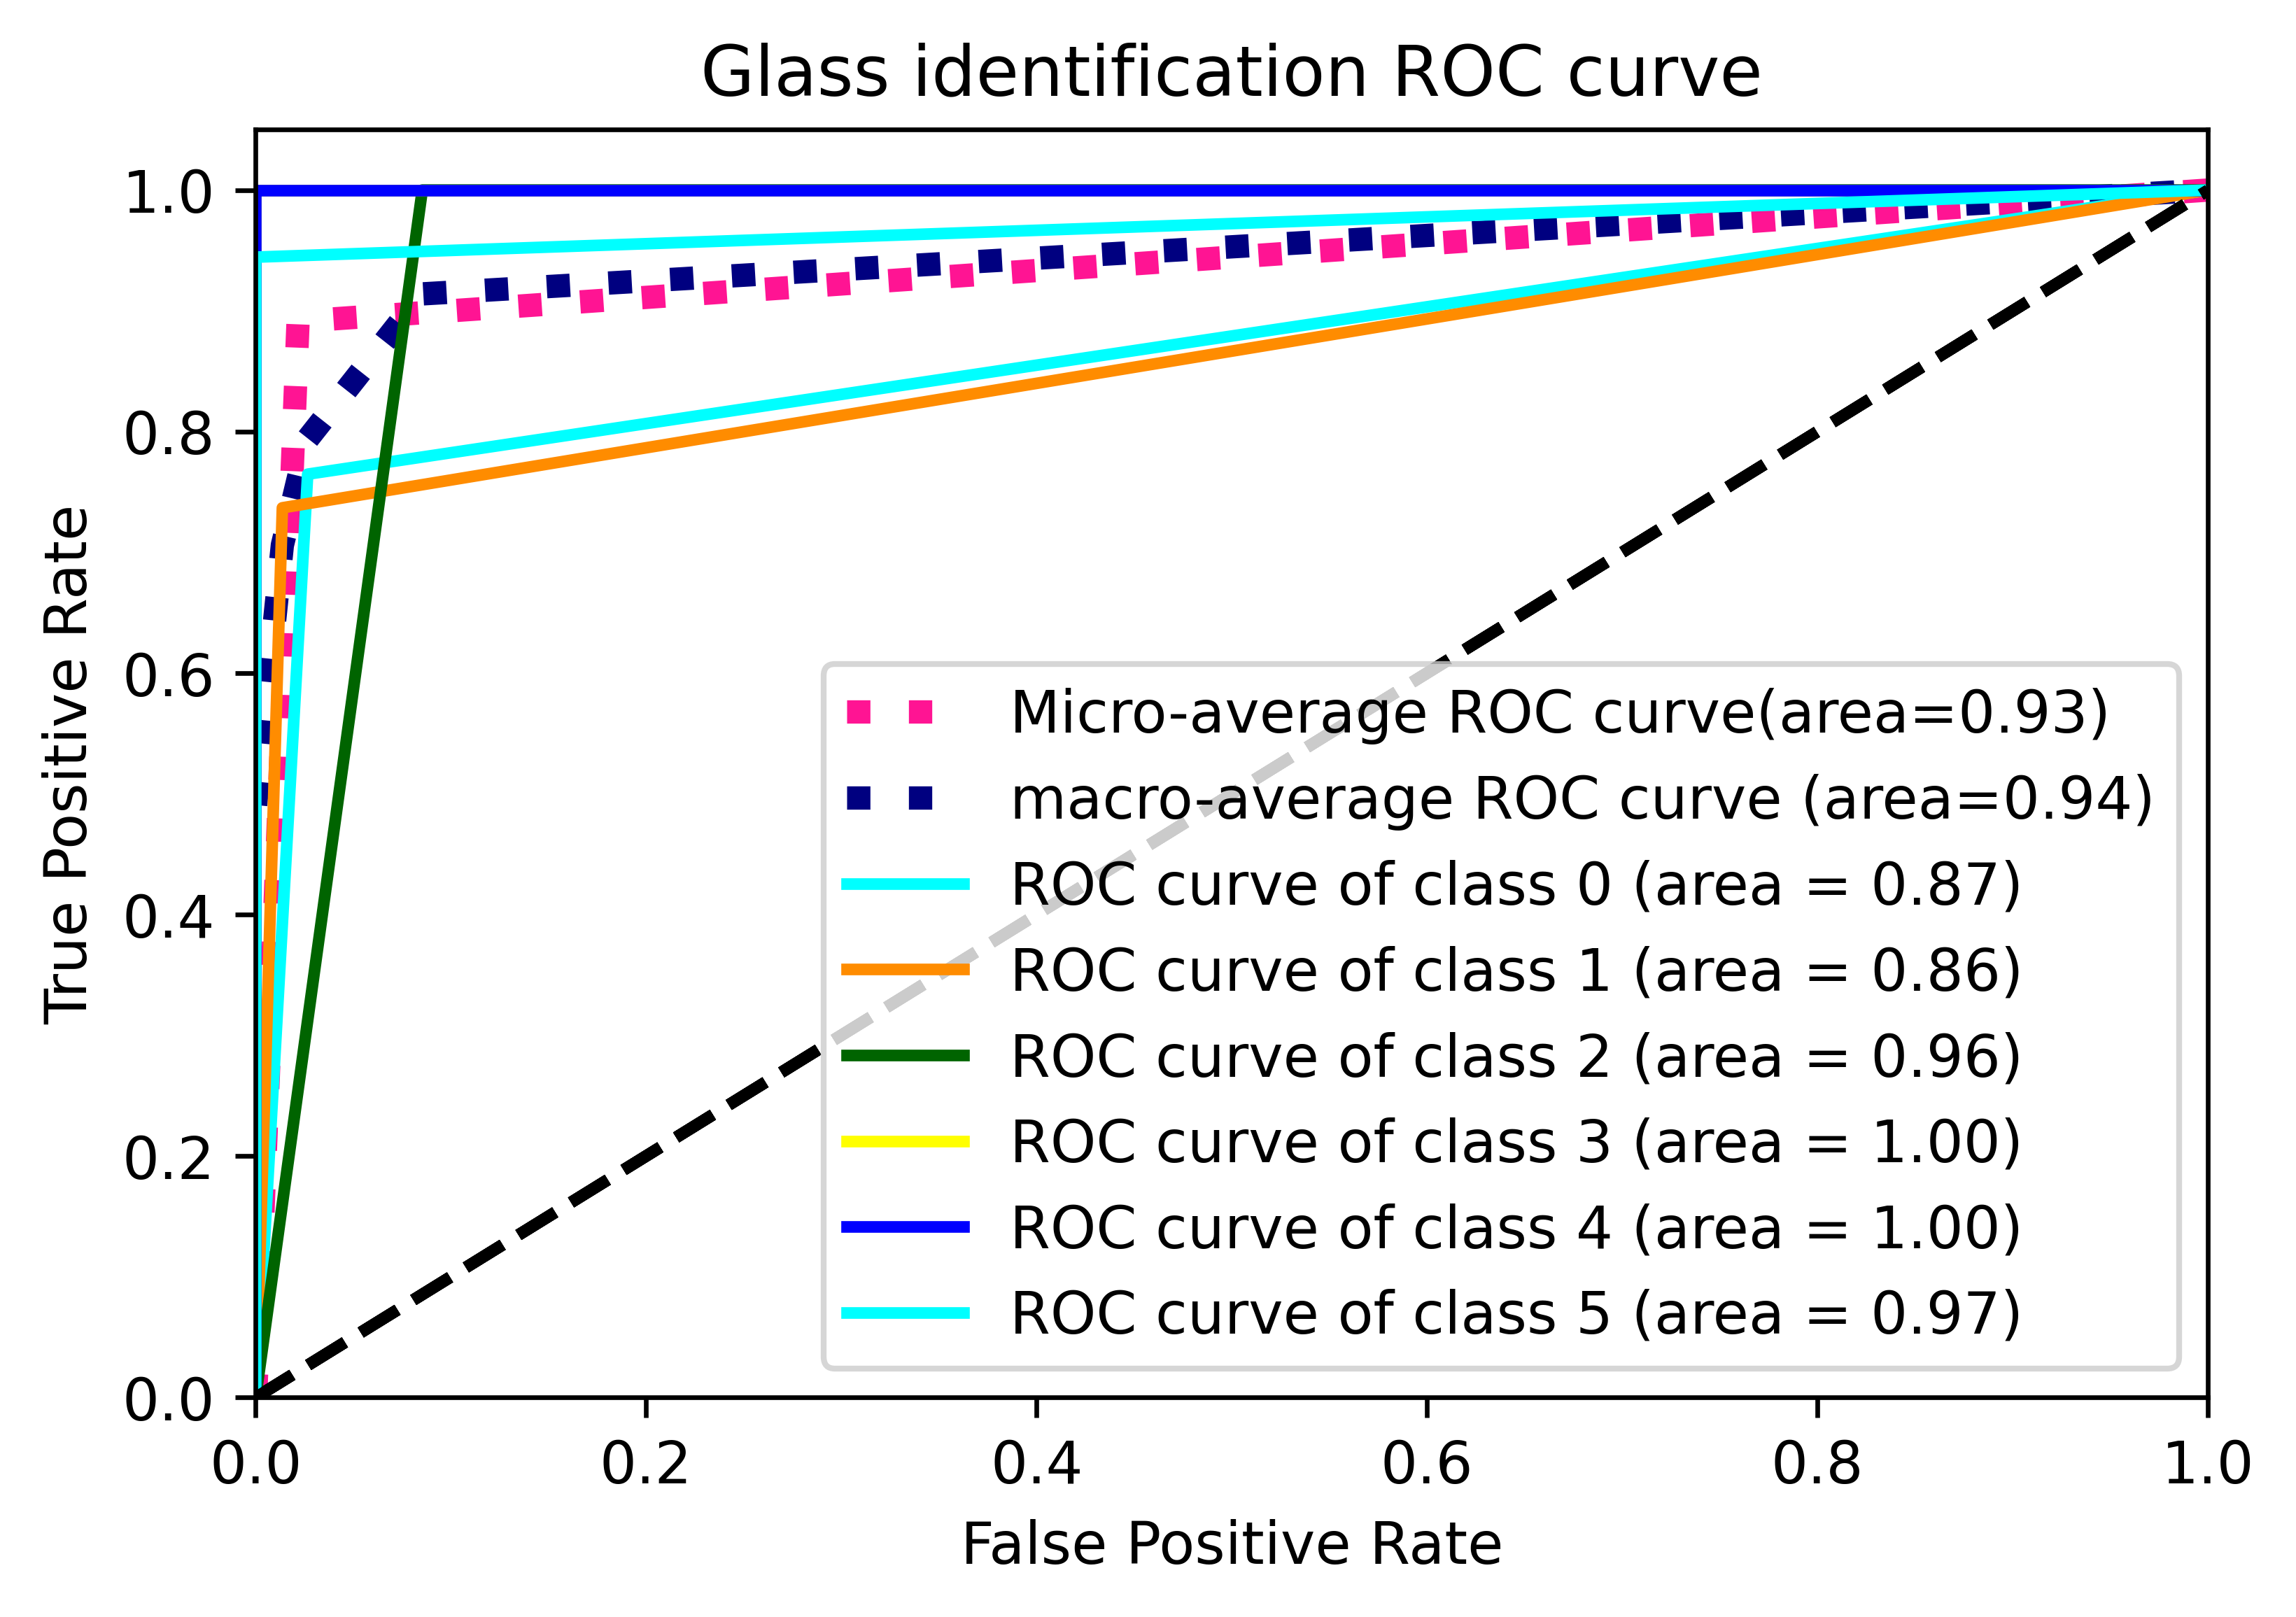

In [14]:
#Plot ROC Curve for KNN model
plot_roc_curve(y_test, knn_pred)

## Creating ANN Model

In [15]:
def ann_model(X_train, y_train):
    #Set random seed
    set_seed(42)
    #Initialize a callback object using 'loss'
    callback = EarlyStopping(monitor='loss', patience=4)

    #Create the ANN model and add layers
    model = Sequential()
    model.add(Dense(100, activation = 'relu', input_shape = (X_train.shape[1],)))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(6, activation = 'softmax'))

    #Compile the model
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', 
                  metrics=['sparse_categorical_accuracy'])

    #Fit the model using the training set and return the fitted model
    model.fit(X_train, y_train, verbose=0, epochs = 500, callbacks=callback)
    return model

In [16]:
#Generate the ANN model using the 
ann = ann_model(X_train, y_train)
#Obtain the predicted y scores using X_train (to check for underfitting)
ann_train = np.argmax(ann.predict(X_train), axis=1)
#Obtain the predicted y scores using X_test
ann_pred = np.argmax(ann.predict(X_test), axis=1)

#Create a DataFrame of the X_test values, the features, and the true and predicted labels
ann_glass = pd.DataFrame(X_test, columns=df_glass.columns[:-1])
ann_glass['True Labels'] = y_test
ann_glass['Predicted Labels'] = ann_pred
ann_glass.head()

,RI/Refractive index,Na/Sodium,MG/Magnesium,Al/Aluminum,Si/Silicon,K/Potassium,Ca/Calcium,Ba/Barium,Fe/Iron,True Labels,Predicted Labels
0,0.135055,0.551791,0.059731,0.187383,-0.033797,-0.542165,0.124287,-0.409449,-0.484393,4,4
1,1.484824,0.691866,1.117635,-2.042471,-1.209769,-0.426463,0.303348,-0.409449,-0.484393,0,0
2,0.297541,-1.056977,-1.366769,0.252890,1.433026,0.006544,1.493382,-0.409449,-0.484393,3,3
3,0.308328,-0.092542,0.859400,-0.489995,-0.898267,0.054809,-0.140701,-0.409449,-0.484393,0,0
4,-0.640440,-0.656790,0.844480,-0.560045,0.419627,0.004788,-0.417911,-0.409449,-0.484393,2,2


In [17]:
#Obtain the accuracy score of the training data (to check for underfitting)
print(accuracy_score(y_train, ann_train))

0.9423076923076923


In [18]:
#Obtain the accuracy score of the test data (to check for overfitting and for the model's accuracy)
print(accuracy_score(y_test, ann_pred))

0.9239130434782609


In [19]:
#Generate the classification report for the model
print(classification_report(y_test, ann_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        17
           1       0.88      0.79      0.83        19
           2       0.83      1.00      0.91        10
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        18

    accuracy                           0.92        92
   macro avg       0.92      0.94      0.93        92
weighted avg       0.92      0.92      0.92        92



## Plotting ANN

In [20]:
#Generate the visualization for the ANN Model
ann_viz(ann, title = f'ANN Accuracy Score: {round(ann.evaluate(X_test, y_test, verbose=0)[1], 2)}')

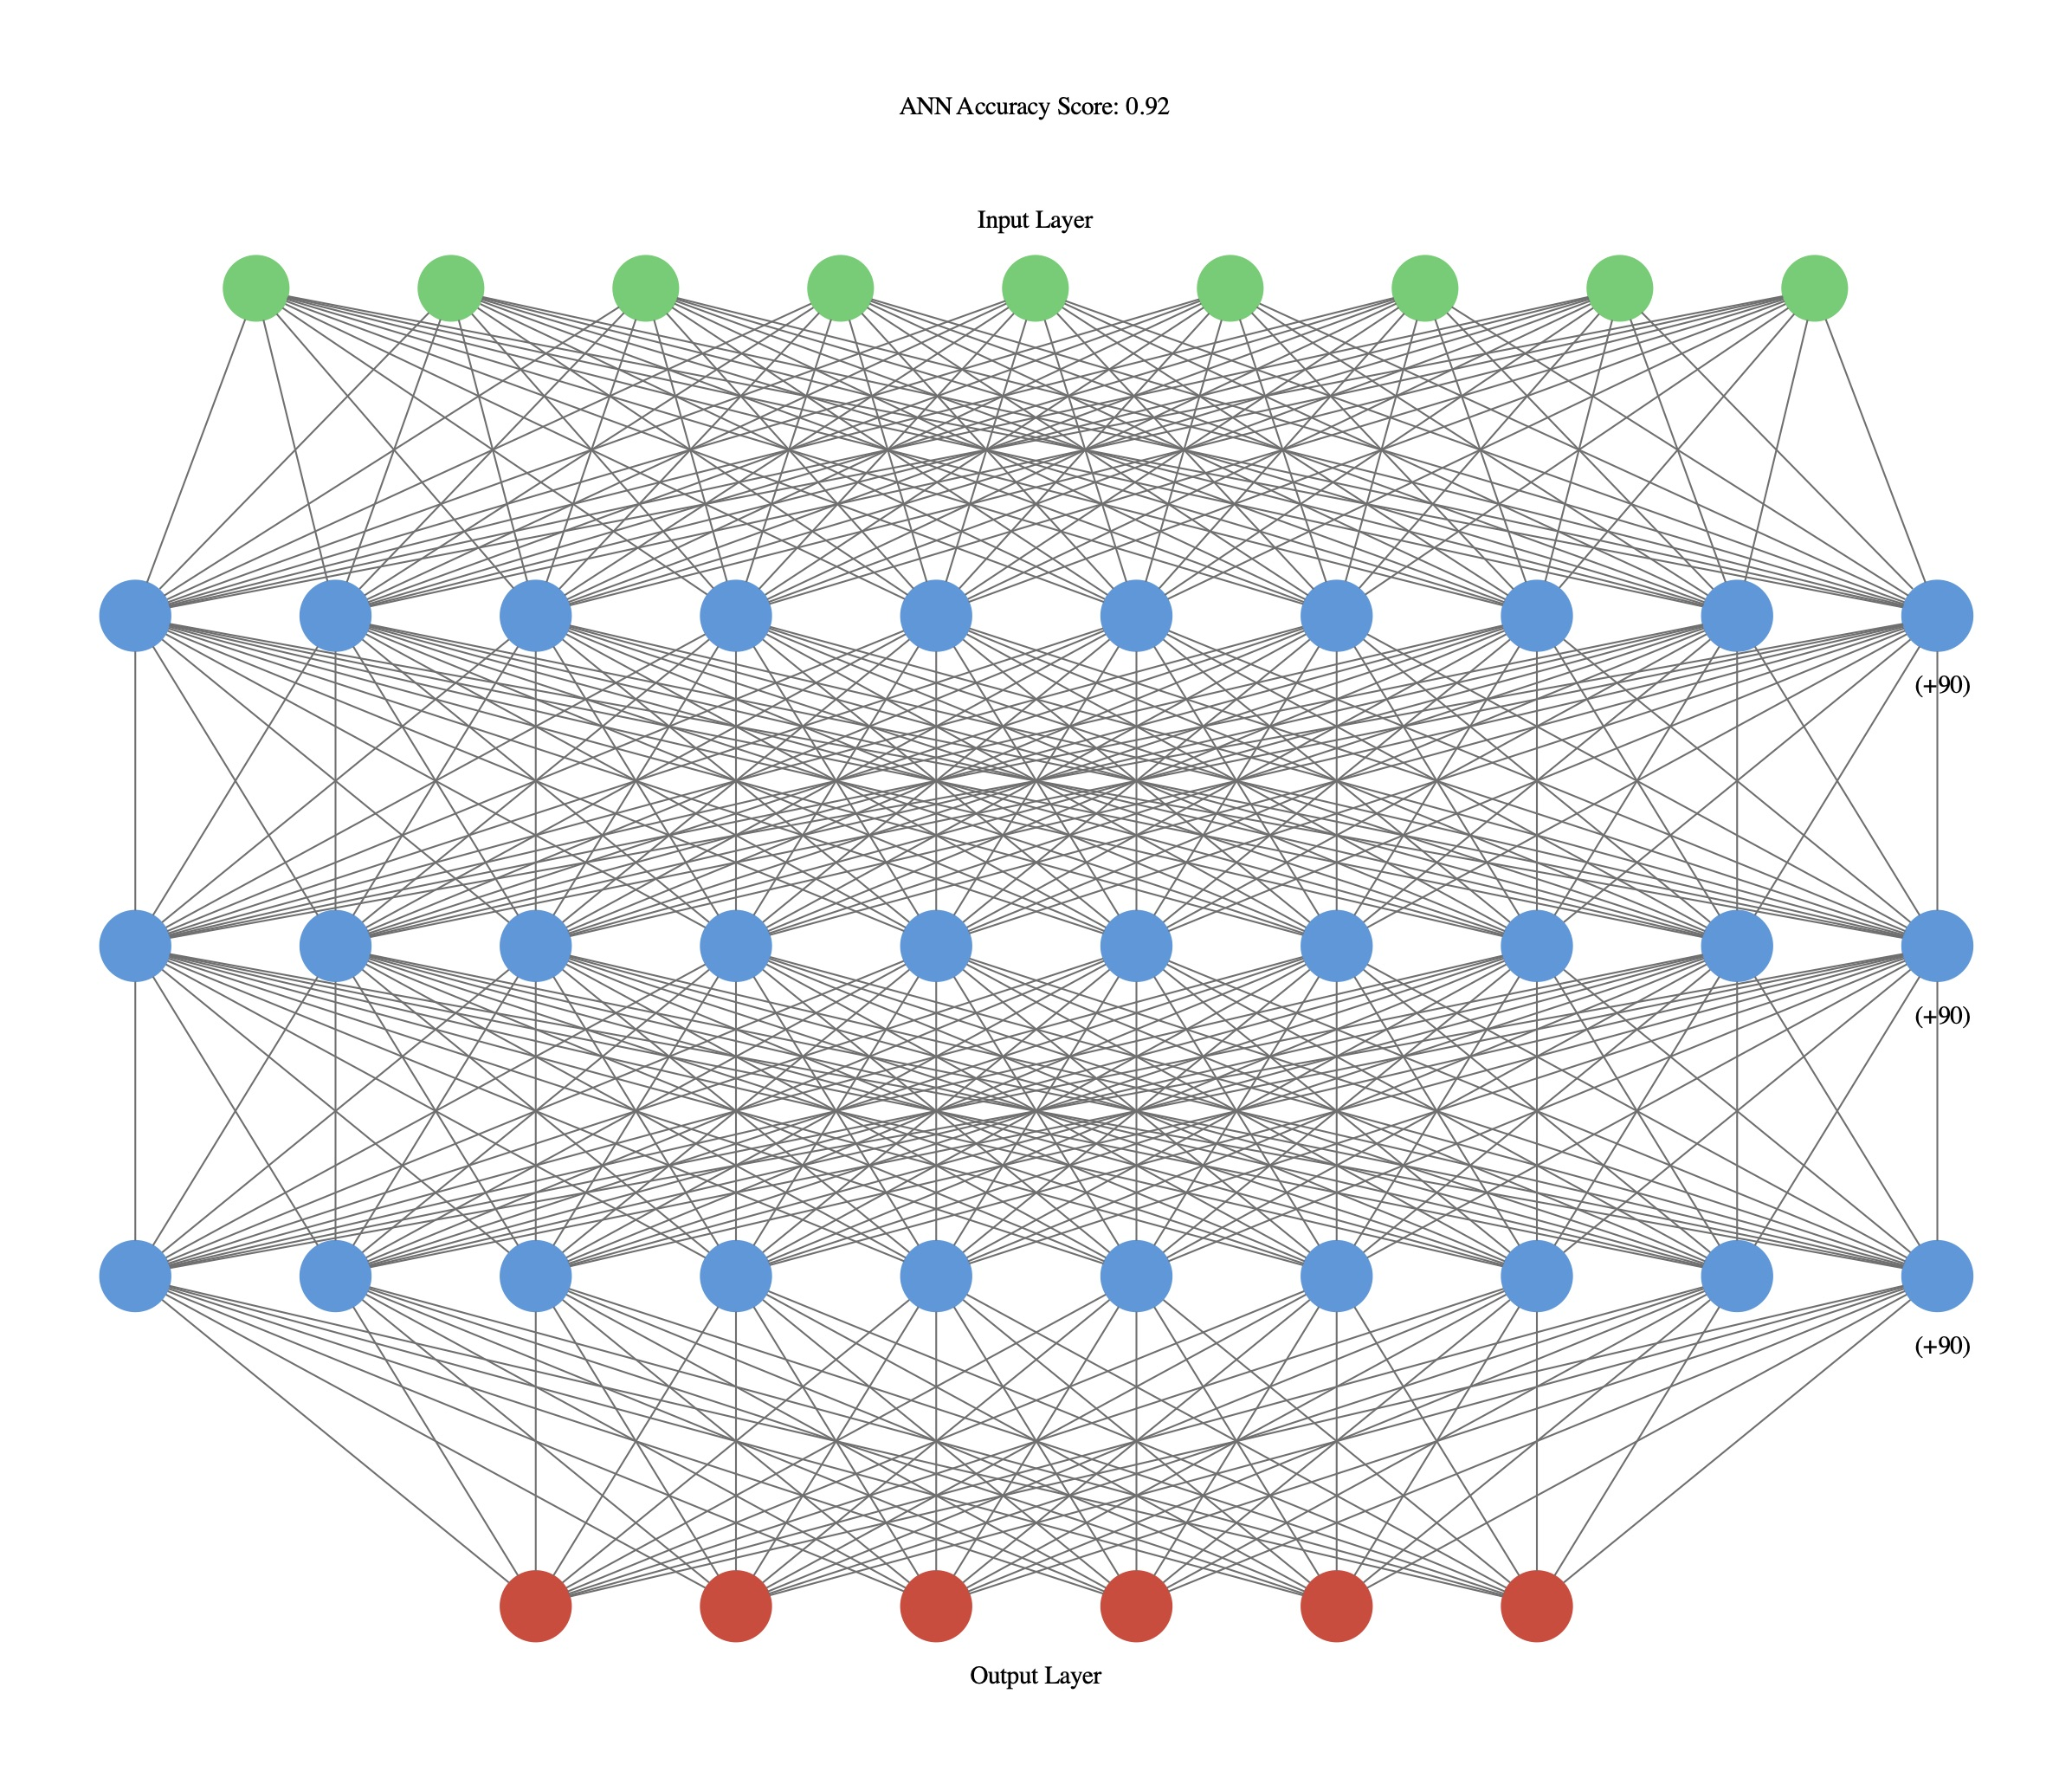

## Plotting ROC Curve for ANN

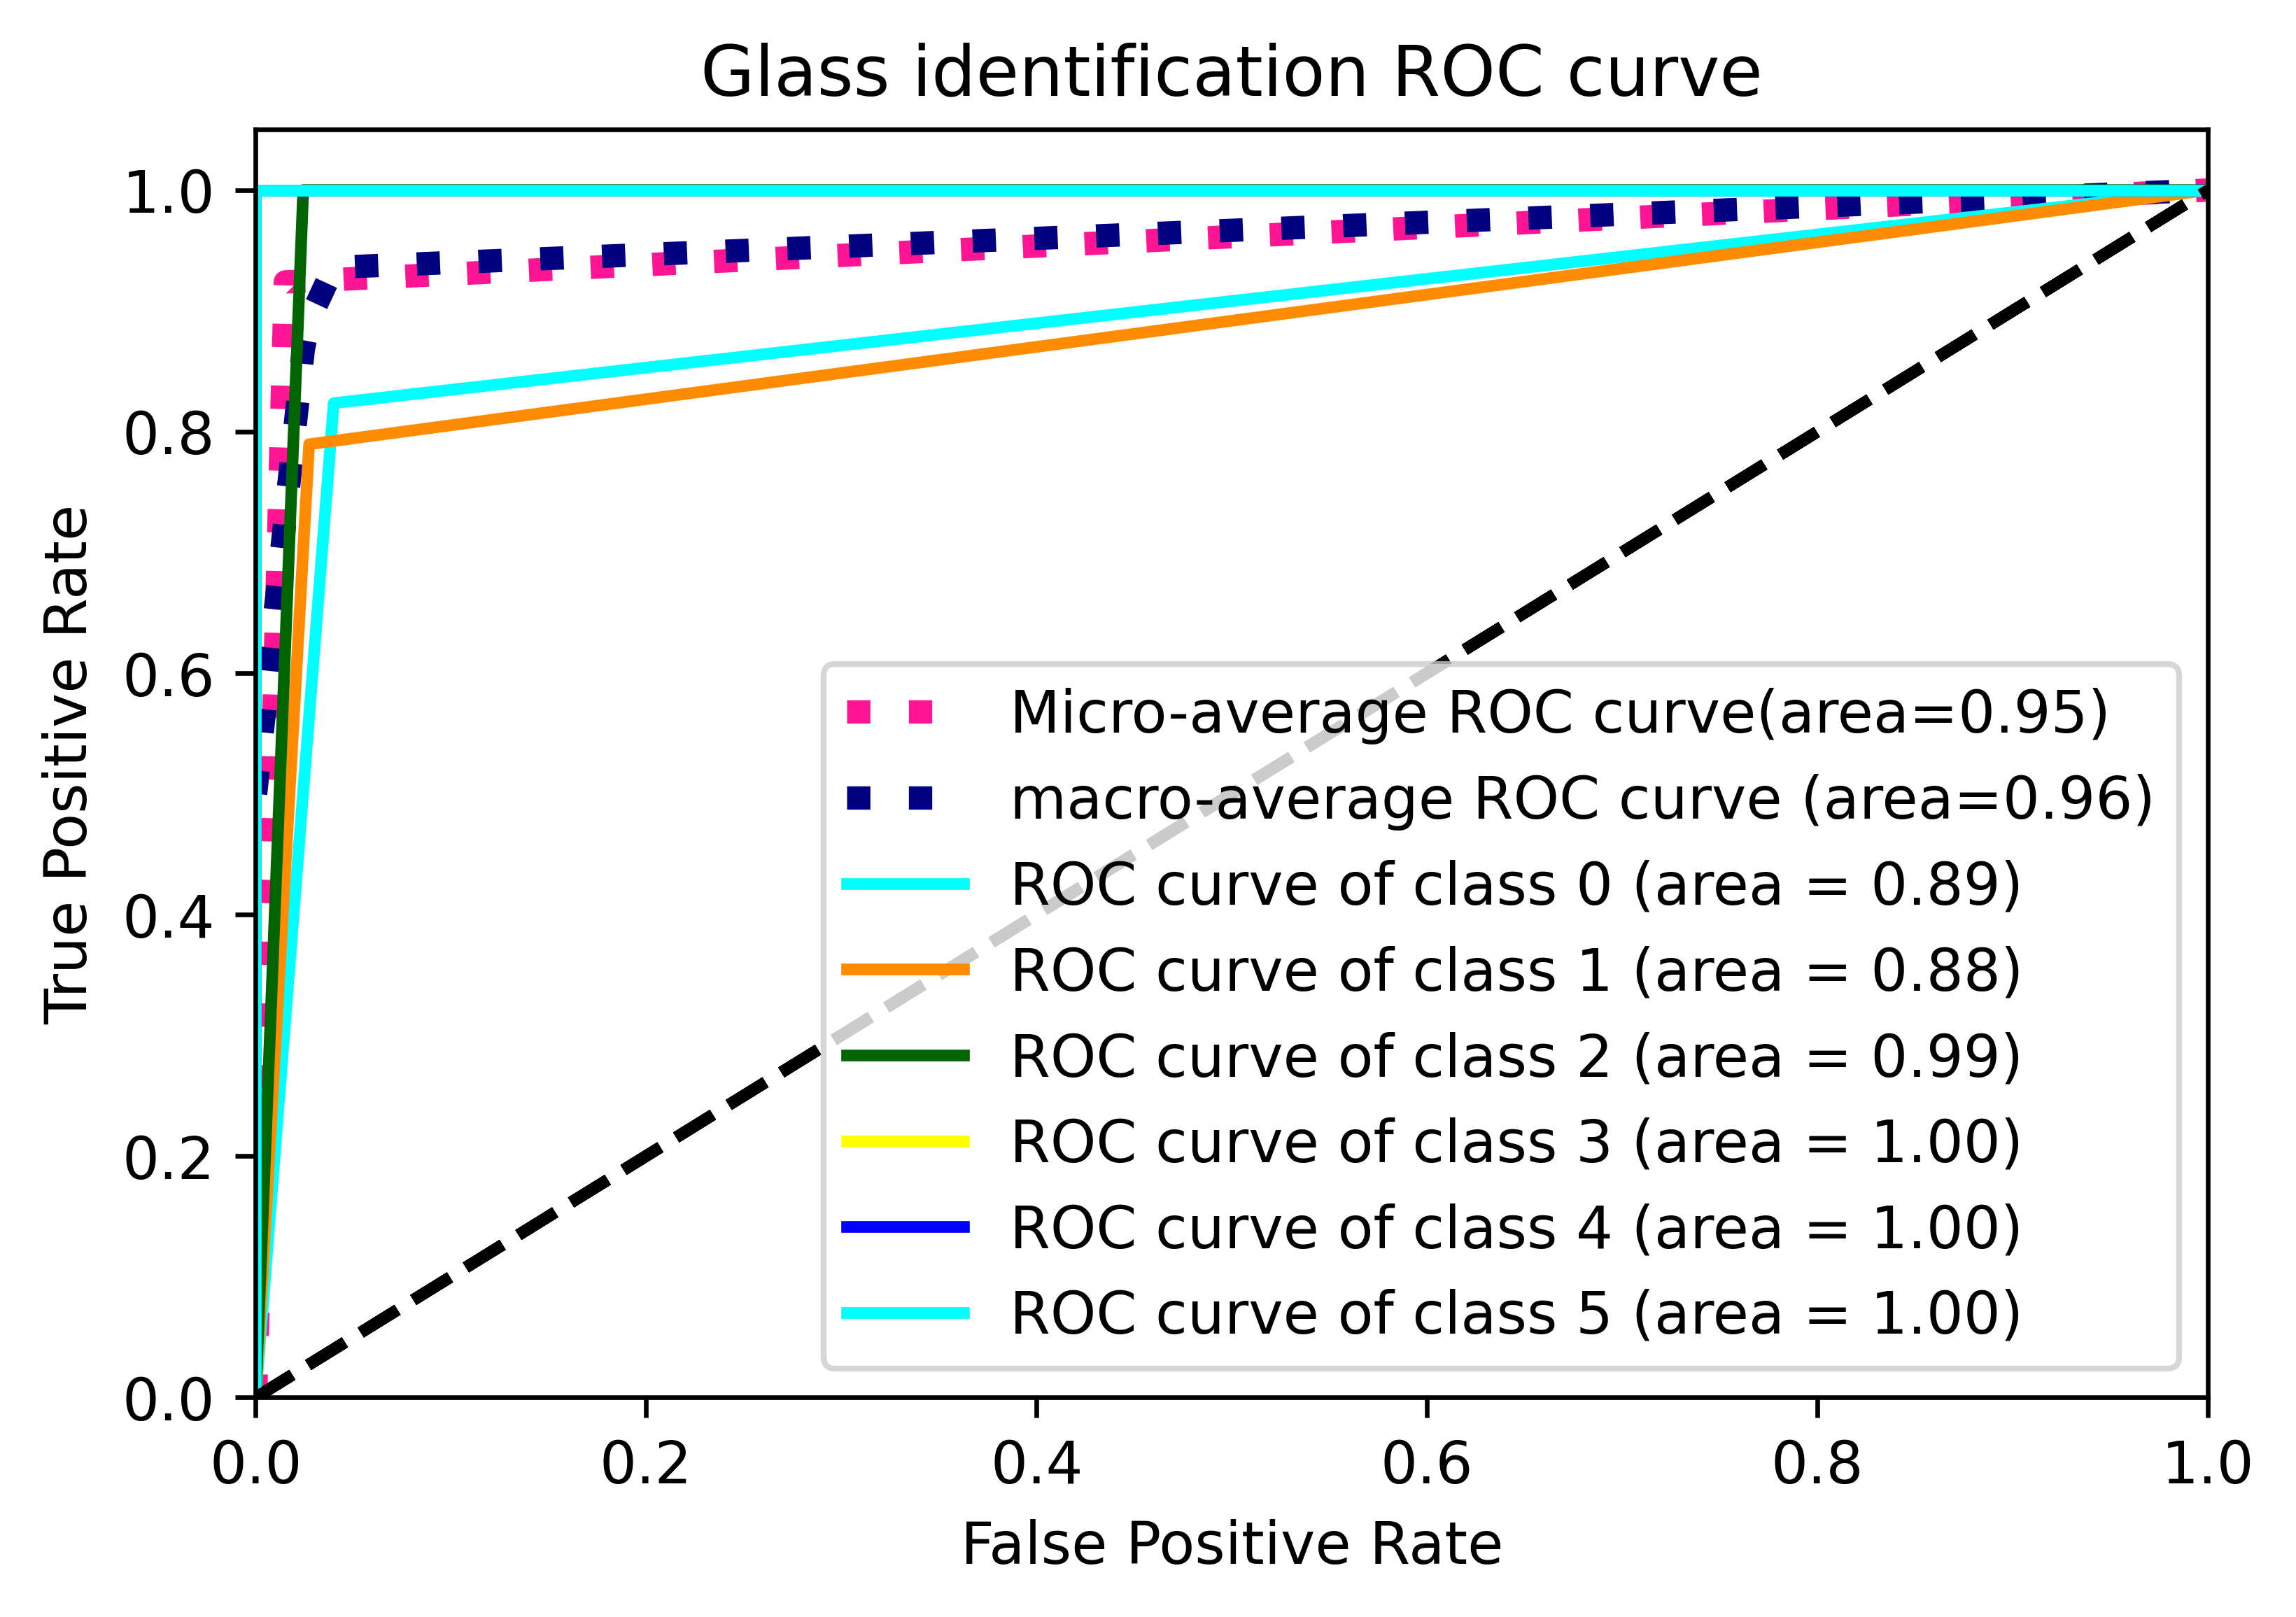

In [21]:
#Plot ROC Curve for ANN model
plot_roc_curve(y_test, ann_pred)

In [5]:
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import pyplot
#import plotly.express as px
from itertools import cycle
from sklearn import metrics
from numpy import where
import seaborn as sns
import pandas as pd
import numpy as np
import psycopg2
#import keyring
import os

# Data

In [6]:
df_glass = pd.read_csv('glass (1).csv')
df_glass

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


In [7]:
# checking for nulls
df_glass.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

In [8]:
# checking for na
df_glass.isna().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

In [9]:
# checking for duplicates
df_glass[df_glass.duplicated()]

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.0,1


In [10]:
# one duplicate found and drop it.
df_glass.drop_duplicates(keep='last',inplace=True)

In [11]:
# checking one more time to make sure there is no duplicates.
df_glass.duplicated().sum()

0

In [12]:
# data is clean now
df_glass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      213 non-null    float64
 1   Na      213 non-null    float64
 2   Mg      213 non-null    float64
 3   Al      213 non-null    float64
 4   Si      213 non-null    float64
 5   K       213 non-null    float64
 6   Ca      213 non-null    float64
 7   Ba      213 non-null    float64
 8   Fe      213 non-null    float64
 9   Type    213 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 18.3 KB


In [13]:
# renaming columns for better understanding.
df_glass.rename(columns = {'RI':'RI/Refractive index', 'Na':'Na/Sodium', 'Mg': 'MG/Magnesium', 'Al': 'Al/Aluminum', 'Si': 'Si/Silicon', 'K':'K/Potassium', 'Ca':'Ca/Calcium','Ba': 'Ba/Barium', 'Fe': 'Fe/Iron' }, inplace = True)
df_glass

,RI/Refractive index,Na/Sodium,MG/Magnesium,Al/Aluminum,Si/Silicon,K/Potassium,Ca/Calcium,Ba/Barium,Fe/Iron,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


Objective: determine which class the glass sample belongs to

There are seven types of glass listed: they are :

- Class 1: building windows(float processed)
- Class 2: biulding windows(non-float processed)
- Class 3: vehicle windows(float processed)
- Class 4: vehicle windows(non-flaot processed)
- Class 5: containers
- Class 6: tableware
- Class 7: headlamps

Pie plot to visually demonstrate break down by glass types

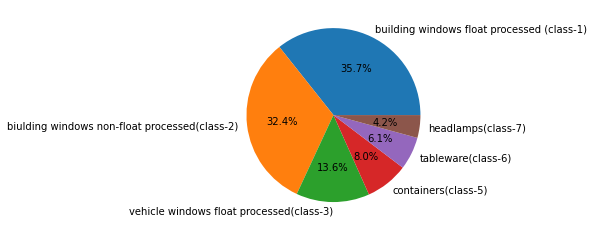

In [13]:
# pie plot: 
value_type = np.array(df_glass["Type"].value_counts())
name_type = ["building windows float processed (class-1)","biulding windows non-float processed(class-2)","vehicle windows float processed(class-3)","containers(class-5)","tableware(class-6)","headlamps(class-7)"]
plt.pie(value_type,labels = name_type, autopct='%1.1f%%')
#plt.legend(title = "Target Variable Distribution")
plt.show()

In [14]:
#using describe to understand data better.
df_glass.describe()

,RI/Refractive index,Na/Sodium,MG/Magnesium,Al/Aluminum,Si/Silicon,K/Potassium,Ca/Calcium,Ba/Barium,Fe/Iron,Type
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,1.518348,13.404085,2.679202,1.449484,72.655070,0.498873,8.954085,0.175869,0.057277,2.788732
std,0.003033,0.816662,1.443691,0.495925,0.773998,0.653185,1.425882,0.498245,0.097589,2.105130
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516520,12.900000,2.090000,1.190000,72.280000,0.130000,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.560000,8.600000,0.000000,0.000000,2.000000
75%,1.519150,13.810000,3.600000,1.630000,73.090000,0.610000,9.150000,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


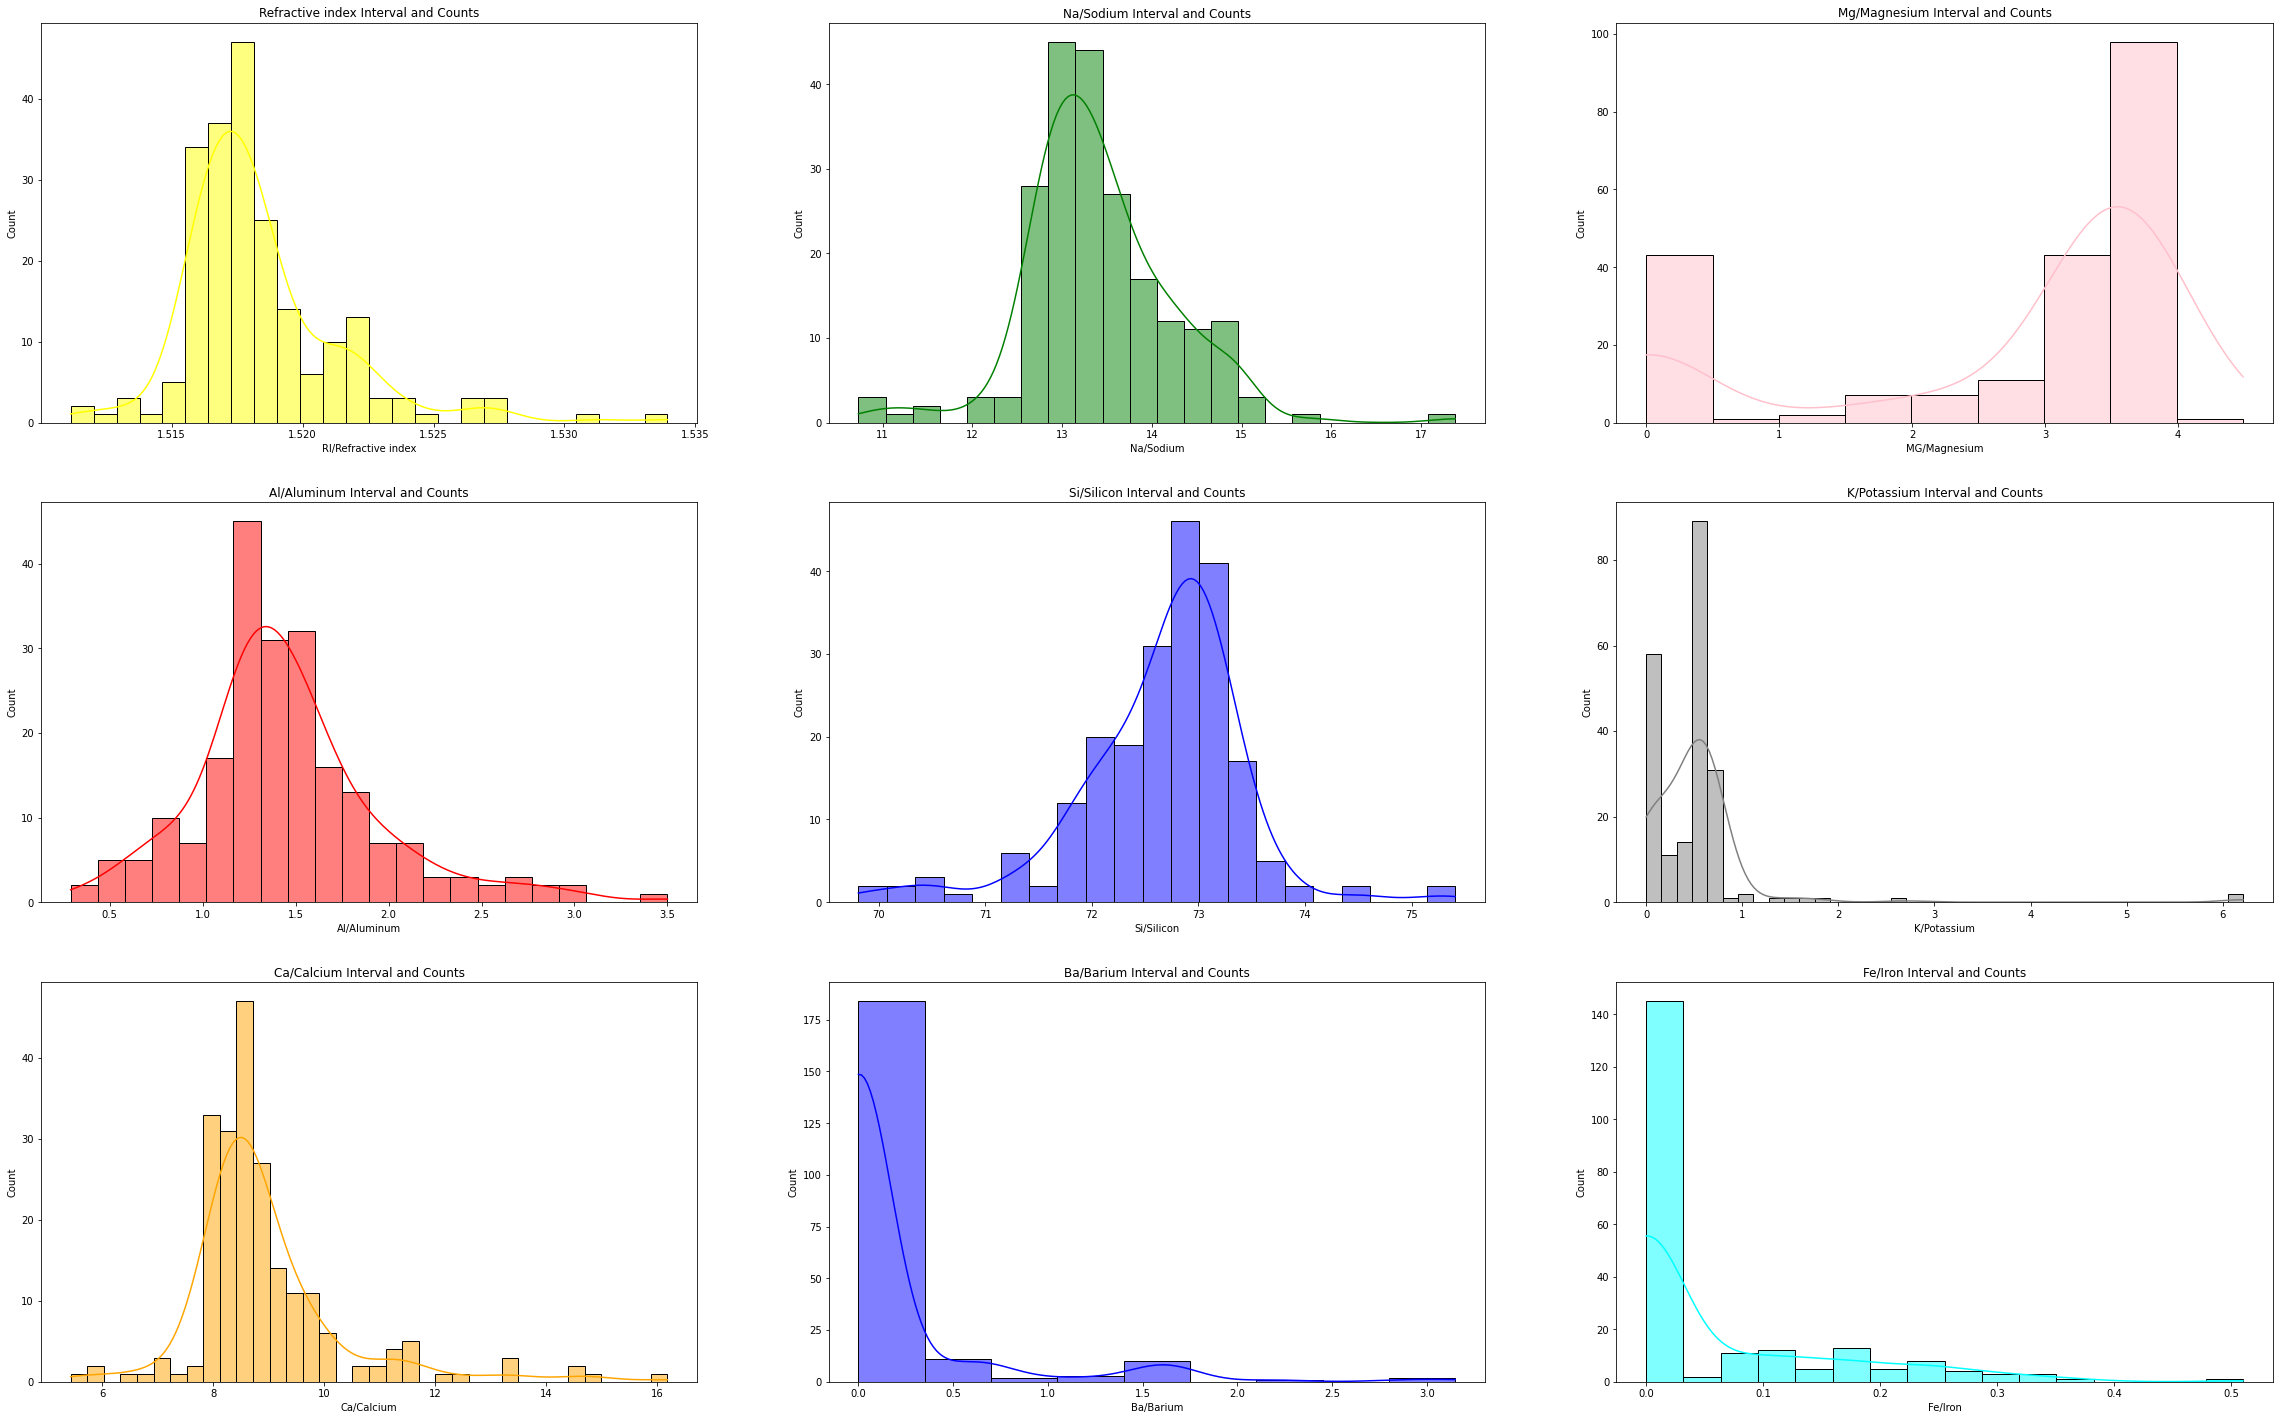

In [15]:
plt.figure(figsize=(40,25))
plt.subplot(3,3,1)
sns.histplot(df_glass['RI/Refractive index'],color = 'yellow',kde = True).set_title('Refractive index Interval and Counts')
plt.subplot(3,3,2)
sns.histplot(df_glass['Na/Sodium'],color = 'green',kde = True).set_title('Na/Sodium Interval and Counts')
plt.subplot(3,3,3)
sns.histplot(df_glass['MG/Magnesium'],kde = True,color = 'pink',).set_title('Mg/Magnesium Interval and Counts')
plt.subplot(3,3,4)
sns.histplot(df_glass['Al/Aluminum'],kde = True,color = 'red').set_title('Al/Aluminum Interval and Counts')
plt.subplot(3,3,5)
sns.histplot(df_glass['Si/Silicon'],color = 'blue',kde = True).set_title('Si/Silicon Interval and Counts')
plt.subplot(3,3,6)
sns.histplot(df_glass['K/Potassium'],color = 'grey',kde = True).set_title('K/Potassium Interval and Counts')
plt.subplot(3,3,7)
sns.histplot(df_glass['Ca/Calcium'],color = 'orange',kde = True).set_title('Ca/Calcium Interval and Counts')
plt.subplot(3,3,8)
sns.histplot(df_glass['Ba/Barium'],color = 'blue',kde = True).set_title('Ba/Barium Interval and Counts')
plt.subplot(3,3,9)
sns.histplot(df_glass['Fe/Iron'],color = 'cyan',kde = True).set_title('Fe/Iron Interval and Counts')
plt.show()

correlation matrix shows us that RI/refractive index highly correlated with Ca/calcium, RI/refractive index negatively correlated with Si/silicon.

,RI/Refractive index,Na/Sodium,MG/Magnesium,Al/Aluminum,Si/Silicon,K/Potassium,Ca/Calcium,Ba/Barium,Fe/Iron,Type
RI/Refractive index,1.000000,-0.198802,-0.127526,-0.400973,-0.539000,-0.287645,0.811183,0.001679,0.147083,-0.160140
Na/Sodium,-0.198802,1.000000,-0.278420,0.167735,-0.064885,-0.264158,-0.278194,0.329080,-0.239374,0.508837
MG/Magnesium,-0.127526,-0.278420,1.000000,-0.479575,-0.162437,0.007617,-0.446197,-0.491818,0.085426,-0.744195
Al/Aluminum,-0.400973,0.167735,-0.479575,1.000000,-0.016195,0.323683,-0.258068,0.480642,-0.080583,0.597432
Si/Silicon,-0.539000,-0.064885,-0.162437,-0.016195,1.000000,-0.197281,-0.207145,-0.104389,-0.097717,0.147725
K/Potassium,-0.287645,-0.264158,0.007617,0.323683,-0.197281,1.000000,-0.317032,-0.043653,-0.009372,-0.012455
Ca/Calcium,0.811183,-0.278194,-0.446197,-0.258068,-0.207145,-0.317032,1.000000,-0.112208,0.126314,0.002677
Ba/Barium,0.001679,0.329080,-0.491818,0.480642,-0.104389,-0.043653,-0.112208,1.000000,-0.059729,0.574896
Fe/Iron,0.147083,-0.239374,0.085426,-0.080583,-0.097717,-0.009372,0.126314,-0.059729,1.000000,-0.191090
Type,-0.160140,0.508837,-0.744195,0.597432,0.147725,-0.012455,0.002677,0.574896,-0.191090,1.000000


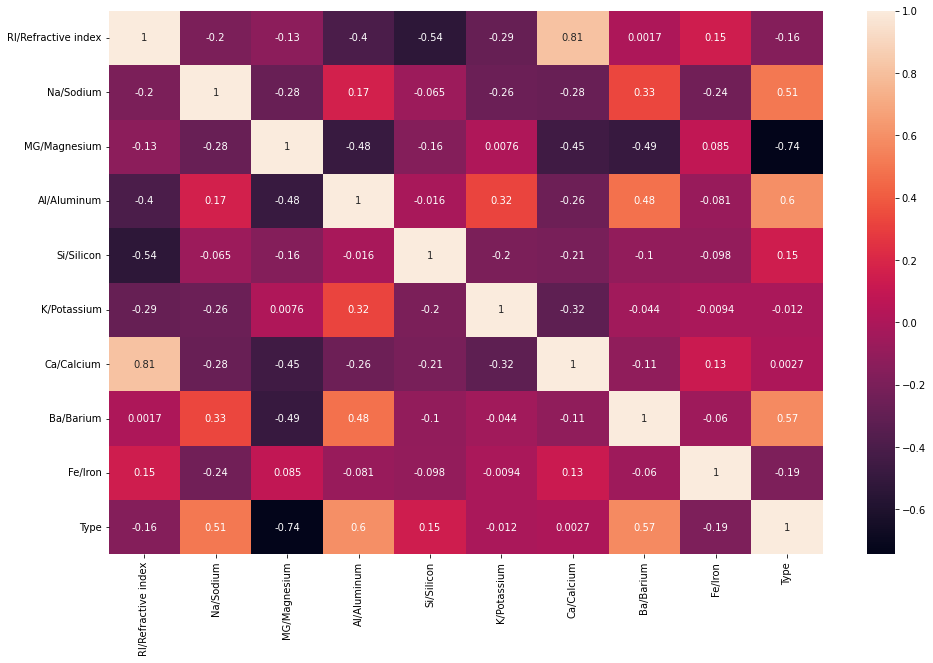

In [16]:
corr_matrix = df_glass.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_matrix,annot=True)
corr_matrix

This plot used to check wheather output are balenced or not.

[Text(0.5, 1.0, 'Imbalanced glass types')]

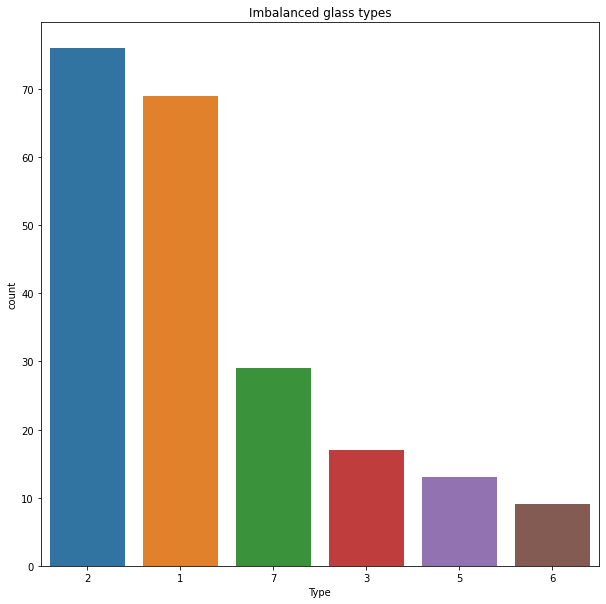

In [17]:
plt.figure(figsize=(10,10))
sns.countplot(x='Type', data=df_glass, order=df_glass['Type'].value_counts().index).set(title='Imbalanced glass types')
#sns.set("Imbalanced glass types")

In [14]:
def smote_balance(data_1):
    data = data_1.values
    # split into input and output elements
    X, y = data[:, :-1], data[:, -1]
    # label encode the target variable
    y = LabelEncoder().fit_transform(y)
    # transform the dataset
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
    return X,y

In [15]:
X, y = smote_balance(df_glass)

Function split and standardize data

In [16]:
def split_train_sc(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)
    #Standardize
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return (X_train,X_test,y_train,y_test)    

In [17]:
X_train, X_test, y_train, y_test = split_train_sc(X,y)

In [18]:
def RanForClass(X_train,X_test,y_train,y_test):
    global rf
    rf = RandomForestClassifier(random_state = 42)
    params_rf = {'n_estimators': [50,100,150,200,250],
                'max_depth': [4,6,8,10,12,None],
                'min_samples_leaf': [0.001,0.002,0.003,0.004,0.005],
                'max_features': [0.5,1,'log2','sqrt']}
     #GridSearchsv will find best parameter for our model
    grid_rf = GridSearchCV(estimator = rf,param_grid = params_rf,cv = 5)
    grid_rf.fit(X_train,y_train)
    best_hyperparams = grid_rf.best_params_
    # Extract the best model from 'grid_rf'
    best_model = grid_rf.best_estimator_
    global pred_train
    pred_train = best_model.predict(X_train)
    #Predict the test set labels
    global y_pred_rf
    y_pred_rf = best_model.predict(X_test)
    #add predicted output to dataframe
    pred_glass_df = pd.DataFrame(X_test,columns = df_glass.columns[0:9])
    pred_glass_df['Type'] = y_test.tolist()
    pred_glass_df['predicted_type'] = y_pred_rf.tolist()
    global feat_imp
    feat_imp = best_model.feature_importances_
    return pred_glass_df.head(10)

   

In [ ]:
RanForClass(X_train, X_test, y_train, y_test)

In [ ]:
#Train Accuracy_score
print(accuracy_score(y_train,pred_train))

In [ ]:
# Test Accuracy_score
print(accuracy_score(y_test,y_pred_rf))

In [ ]:
#Classification_report
print(classification_report(y_test,y_pred_rf))

In [ ]:
def plot_roc_curve(y_test,y_pred):
    num_classes = len(np.unique(y_test))
    y_test = label_binarize(y_test,classes =np.arange(num_classes))
    y_pred = label_binarize(y_pred,classes=np.arange(num_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i],tpr[i],_ = roc_curve(y_test[:, i],y_pred[:, i])
        roc_auc[i] = auc(fpr[i],tpr[i])
        
        
    # Compute micro-average ROC curve and ROC area
    fpr['micro'], tpr['micro'],_ = roc_curve(y_test.ravel(),y_pred.ravel())
    roc_auc['micro'] = auc(fpr['micro'],tpr['micro'])
    
    #First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr +=np.interp(all_fpr,fpr[i], tpr[i])
        
        
    # Finally average it and compute AUC
    mean_tpr/=num_classes
    
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'],tpr['macro'])
    
    # Plot all ROC curves
    # plt.figure(figsize=(10,5))
    plt.figure(dpi=600)
    lw = 2
    plt.plot(fpr['micro'],tpr['micro'],
            label = 'Micro-average ROC curve(area={0:0.2f})'.format(roc_auc['micro']),
            color = 'deeppink', linestyle=':', linewidth=4,)
    
    plt.plot(fpr['macro'],tpr['macro'],
            label = 'macro-average ROC curve (area={0:0.2f})'.format(roc_auc['macro']),
            color='navy', linestyle=':',linewidth=4,)
    
    colors = cycle(['aqua','darkorange','darkgreen','yellow','blue'])
    for i, color in zip(range(num_classes),colors):
        plt.plot(fpr[i],tpr[i],color=color,lw=lw,
                label = 'ROC curve of class {0} (area = {1:0.2f})'.format(i,roc_auc[i]),)
        
        
        plt.plot([0,1],[0,1], 'k--',lw =lw)
        plt.xlim([0.0,1.0])
        plt.ylim([0.0,1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(' RandomForest class types ROC curve')
        plt.legend()

In [ ]:
plot_roc_curve(y_test,y_pred_rf)

Features Importances: we can see that MG/Magnesium is the most important feature.

In [ ]:
df_glass_1 = df_glass.drop('Type', axis=1)
d = {'features':df_glass_1.columns,'FI':feat_imp}
df = pd.DataFrame(d)
df = df.sort_values(by='FI', ascending=0)
fig = px.bar_polar(df, r="FI", theta="features",
                   color="features", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.show()